Import the relevant modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import matplotlib
%matplotlib inline

# To sample the diffusion-weighted directions
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere

# To reconstruct the tables with the acquisition information
from dipy.core.gradients import gradient_table

# To perform the monte-carlo simulations
from dipy.sims.voxel import multi_tensor

# Usefull dti functions
from dipy.reconst.dti import design_matrix as dti_design_matrix
from dipy.reconst.dti import (mean_diffusivity, fractional_anisotropy,
                              decompose_tensor, from_lower_triangular,
                              lower_triangular, mean_diffusivity)
import dipy.reconst.dti as dti
from dipy.reconst.vec_val_sum import vec_val_vect

# To process the free water diffusion tensor imaging
import dipy.reconst.fwdti as fwdti

# To process the standard diffusion kurtosis imaging
from dipy.reconst.utils import dki_design_matrix
import dipy.reconst.dki as dki

# To process the DKI free water elimination model
from fwDKI import (nls_fit_fwdki, _nls_err_func)

Parameters for the Simulations

In [2]:
# ------------- acquisition parameters - dataset 1 --------------
# 6 b0
# 8 b-value = 300
# 30 b-value = 1000
# 30 b-value = 2000
# ---------------------------------------------------------------

SNR = None

# Sample 8 diffusion-weighted directions
theta = np.pi * np.random.rand(8)
phi = 2 * np.pi * np.random.rand(8)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions8 = hsph_updated.vertices # directions for each shell

# Sample 30 diffusion-weighted directions
theta = np.pi * np.random.rand(30)
phi = 2 * np.pi * np.random.rand(30)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions30 = hsph_updated.vertices # directions for each shell

# Create full dataset parameters
bvals = np.hstack((np.zeros(6), 300 * np.ones(8),
                   1000 * np.ones(30), 2000 * np.ones(30)))
bvecs = np.vstack((np.zeros((6, 3)), directions8,
                   directions30, directions30))
gtab = gradient_table(bvals, bvecs)

# Design matrices
dti_design_matrix = dti_design_matrix(gtab)
dki_design_matrix = dki_design_matrix(gtab)

Generate simulations

In [3]:
# ---------------------------------------------------------------
# Generate simulations
# ---------------------------------------------------------------

# Ground truth values of tissue's diffusion tensor and water volume fraction
FW = np.linspace(0, 99, num=100)
Dwater = 3e-3

FSF = np.linspace(0.1, 0.9, num=5)
ADs = 0.99e-3
RDs = 0.00e-3
ADf = 2.26e-3 
RDf = 0.87e-3

mevals = np.array([[Dwater, Dwater, Dwater],
                   [ADs, RDs, RDs],
                   [ADf, RDf, RDf]])

nrep = 1  # number of simulation repetitions
DWI_simulates = np.empty((FSF.size, FW.size, nrep, bvals.size))

for fsf_i in range(FSF.size):
    fsf = FSF[fsf_i]
    for fw_i in range(FW.size):
        fw = FW[fw_i]
        fractions = [fw, (100-fw) * fsf, (100-fw) * (1-fsf)]
        for s_i in range(nrep):
            signal, sticks = multi_tensor(gtab, mevals, S0=100,
                                          angles=[(0, 0), (0, 0), (0, 0)],
                                          fractions=fractions, snr=SNR)
            DWI_simulates[fsf_i, fw_i, s_i, :] = signal 

Lets analyse the importance of the fwDKI model:

1) fwDTI is not able to model tissue's heterogeneity. So
when heterogeneity is present the water volume fraction
is overestimated.

In [4]:
# ---------------------------------------------------------------
# free water elimination DTI model
# ---------------------------------------------------------------
fwdtimodel = fwdti.FreeWaterTensorModel(gtab, cholesky=True, f_transform=True)
fwdtifit = fwdtimodel.fit(DWI_simulates)
fa = fwdtifit.fa
md = fwdtifit.md
f = fwdtifit.f

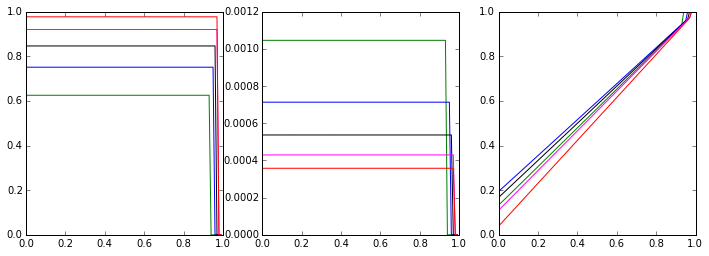

In [5]:
# -----------------------------------------------------------------
# Plot free water DTI measures as function of contamination degree
# -----------------------------------------------------------------

colors = {0: 'g', 1: 'b', 2: 'black', 3: 'magenta', 4: 'r'}

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

mean_fa = np.empty(FW.size)
mean_md = np.empty(FW.size)
mean_f = np.empty(FW.size)

for fsf_i in range(FSF.size):
    for fw_i in range(FW.size):
        mean_fa[fw_i] = np.mean(fa[fsf_i, fw_i, :])
        mean_md[fw_i] = np.mean(md[fsf_i, fw_i, :])
        mean_f[fw_i] = np.mean(f[fsf_i, fw_i, :])
    axs[0].plot(FW/100, mean_fa, color=colors[fsf_i])  
    axs[1].plot(FW/100, mean_md, color=colors[fsf_i])  
    axs[2].plot(FW/100, mean_f, color=colors[fsf_i])  
        
plt.show()

2) DKI measures do not take into account free water contamination.
So when there is free water partial volume effects tissue's heterogeneity
can be overestimated or underestimated depending on the degree of contamination
and the tissue's ground truth properties.

In [6]:
# ---------------------------------------------------------------
# standard  DKI
# ---------------------------------------------------------------
dkimodel = dki.DiffusionKurtosisModel(gtab)
dkifit = dkimodel.fit(DWI_simulates)
fa = dkifit.fa
md = dkifit.md
mk = dkifit.mk()
ak = dkifit.ak()
rk = dkifit.rk()

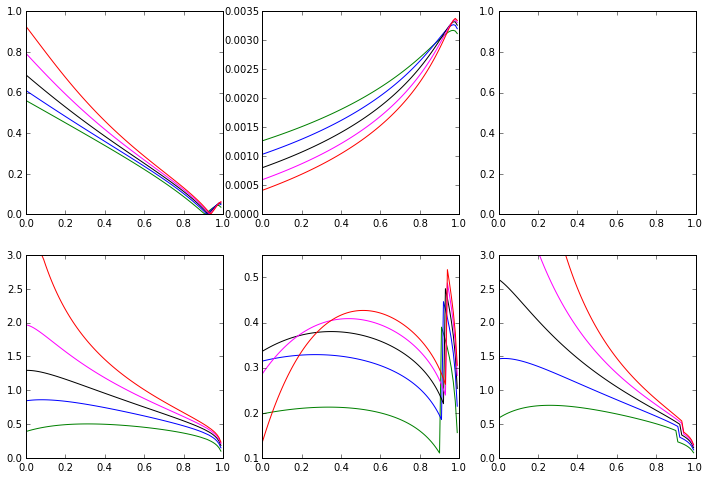

In [7]:
# -----------------------------------------------------------------
# Plot DKI measures as function of contamination degree
# -----------------------------------------------------------------

colors = {0: 'g', 1: 'b', 2: 'black', 3: 'magenta', 4: 'r'}

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

mean_fa = np.empty(FW.size)
mean_md = np.empty(FW.size)
mean_mk = np.empty(FW.size)
mean_ak = np.empty(FW.size)
mean_rk = np.empty(FW.size)

for fsf_i in range(FSF.size):
    for fw_i in range(FW.size):
        mean_fa[fw_i] = np.mean(fa[fsf_i, fw_i, :])
        mean_md[fw_i] = np.mean(md[fsf_i, fw_i, :])
        mean_mk[fw_i] = np.mean(mk[fsf_i, fw_i, :])
        mean_ak[fw_i] = np.mean(ak[fsf_i, fw_i, :])
        mean_rk[fw_i] = np.mean(rk[fsf_i, fw_i, :])
    axs[0, 0].plot(FW/100, mean_fa, color=colors[fsf_i])  
    axs[0, 1].plot(FW/100, mean_md, color=colors[fsf_i])  
    axs[1, 0].plot(FW/100, mean_mk, color=colors[fsf_i])  
    axs[1, 1].plot(FW/100, mean_ak, color=colors[fsf_i])  
    axs[1, 2].plot(FW/100, mean_rk, color=colors[fsf_i])  
        
plt.show()

Now it is time to test the fwDKI model

In [8]:
# ---------------------------------------------------------------
# free water elimination DKI
# ---------------------------------------------------------------
S0 = np.mean(DWI_simulates[:, :, :, bvals==0], axis=3)
fwdki_params, S0out = nls_fit_fwdki(dti_design_matrix, dki_design_matrix,
                                    DWI_simulates, S0,
                                    params=None, Diso=3e-3,
                                    f_transform=True, mdreg=2.7e-3)
f = fwdki_params[..., 27]
evals = fwdki_params[..., :3]
fa = dti.fractional_anisotropy(evals)
md = dti.mean_diffusivity(evals)
mk = dki.mean_kurtosis(fwdki_params[..., :27])
ak = dki.axial_kurtosis(fwdki_params[..., :27])
rk = dki.radial_kurtosis(fwdki_params[..., :27])

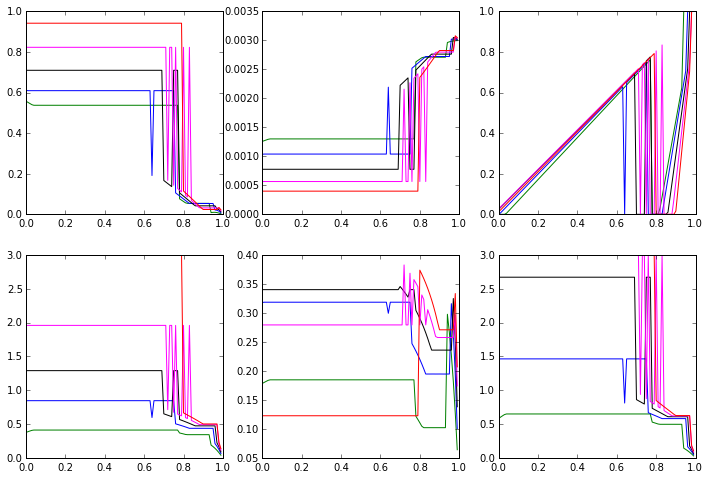

In [10]:
# -----------------------------------------------------------------
# Plot DKI measures as function of contamination degree
# -----------------------------------------------------------------

colors = {0: 'g', 1: 'b', 2: 'black', 3: 'magenta', 4: 'r'}

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

mean_f = np.empty(FW.size)
mean_fa = np.empty(FW.size)
mean_md = np.empty(FW.size)
mean_mk = np.empty(FW.size)
mean_ak = np.empty(FW.size)
mean_rk = np.empty(FW.size)

for fsf_i in range(FSF.size):
    for fw_i in range(FW.size):
        mean_f[fw_i] = np.mean(f[fsf_i, fw_i, :])
        mean_fa[fw_i] = np.mean(fa[fsf_i, fw_i, :])
        mean_md[fw_i] = np.mean(md[fsf_i, fw_i, :])
        mean_mk[fw_i] = np.mean(mk[fsf_i, fw_i, :])
        mean_ak[fw_i] = np.mean(ak[fsf_i, fw_i, :])
        mean_rk[fw_i] = np.mean(rk[fsf_i, fw_i, :])
    axs[0, 0].plot(FW/100, mean_fa, color=colors[fsf_i])  
    axs[0, 1].plot(FW/100, mean_md, color=colors[fsf_i])
    axs[0, 2].plot(FW/100, mean_f, color=colors[fsf_i])  
    axs[1, 0].plot(FW/100, mean_mk, color=colors[fsf_i])  
    axs[1, 1].plot(FW/100, mean_ak, color=colors[fsf_i])  
    axs[1, 2].plot(FW/100, mean_rk, color=colors[fsf_i])  
        
plt.show()